**Construção do modelo com Algoritmos de Machine Learning**

**Modelo 1: Regressão Logística**

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, length, dayofweek, when
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from pyspark.ml.feature import Bucketizer
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
import os

spark = SparkSession.builder \
    .appName("LogisticRegressionExample") \
    .getOrCreate()


df = spark.read.parquet("dataset/text.parquet")


df.printSchema()
df.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/08 14:56:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/06/08 14:56:56 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


root
 |-- reviewText: string (nullable = true)
 |-- class: double (nullable = true)

+--------------------+-----+
|          reviewText|class|
+--------------------+-----+
|shirt was good ju...|  1.0|
|well spent money ...|  1.0|
|i ordered the siz...|  1.0|
|i live in these f...|  1.0|
|i love these this...|  1.0|
+--------------------+-----+
only showing top 5 rows



In [2]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml import Pipeline
import pyspark.sql.functions as F
from pyspark.sql.functions import to_timestamp, col, regexp_replace
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.storagelevel import StorageLevel
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Assuming df is already defined and loaded with data
# Checking for class imbalance
class_distribution = df.groupBy("class").count().orderBy("class")
class_distribution.show()

# Undersample the majority class
min_class_count = class_distribution.agg({"count": "min"}).collect()[0][0]
print("Minimum class count:", min_class_count)

undersampled_df = df.groupBy("class").applyInPandas(
    lambda pdf: pdf.sample(n=min_class_count, random_state=42) if len(pdf) > min_class_count else pdf,
    schema=df.schema
)

undersampled_df.show()

class_distribution_undersampled_df = undersampled_df.groupBy("class").count().orderBy("class")
class_distribution_undersampled_df.show()

# Preprocessing stages
tokenizer = Tokenizer(inputCol="reviewText", outputCol="tokens")
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
hashingTF = HashingTF(inputCol="filtered_tokens", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Split the data into training and testing sets
train_df, test_df = undersampled_df.randomSplit([0.8, 0.2], seed=42)

train_df.persist(StorageLevel.MEMORY_AND_DISK)



+-----+-----+
|class|count|
+-----+-----+
|  0.0| 1184|
|  1.0| 4354|
+-----+-----+

Minimum class count: 1184


+--------------------+-----+
|          reviewText|class|
+--------------------+-----+
|i love analog wat...|  0.0|
|i had an older ci...|  0.0|
|they are a little...|  0.0|
|overall these a f...|  0.0|
|it looked so arti...|  0.0|
|it s like it s sh...|  0.0|
|i love the way th...|  0.0|
|looks like what i...|  0.0|
|i was looking for...|  0.0|
|the medium i orde...|  0.0|
|as a tall woman l...|  0.0|
|i didn t realize ...|  0.0|
|i was very disapp...|  0.0|
|no magnetic closu...|  0.0|
|i purchased this ...|  0.0|
|it s not lined so...|  0.0|
|its a beautiful a...|  0.0|
|i bought this bel...|  0.0|
|not only the size...|  0.0|
|like smaller than...|  0.0|
+--------------------+-----+
only showing top 20 rows

+-----+-----+
|class|count|
+-----+-----+
|  0.0| 1184|
|  1.0| 1184|
+-----+-----+



DataFrame[reviewText: string, class: double]

Training Logistic Regression...


24/06/08 14:57:05 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/08 14:57:05 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/08 14:57:06 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/06/08 14:57:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/08 14:57:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/08 14:57:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/08 14:57:07 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/08 14:57:07 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/08 14:57:07 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/08 14:57:08 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/08 14:57:08 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/08 14:57:08 WARN DAGSchedul

Logistic Regression Test Accuracy = 0.93


24/06/08 14:57:19 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


Class 0.0:
  Precision = 0.96
  Recall = 0.91
  F1 Score = 0.93
Class 1.0:
  Precision = 0.90
  Recall = 0.95
  F1 Score = 0.93


24/06/08 14:57:19 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


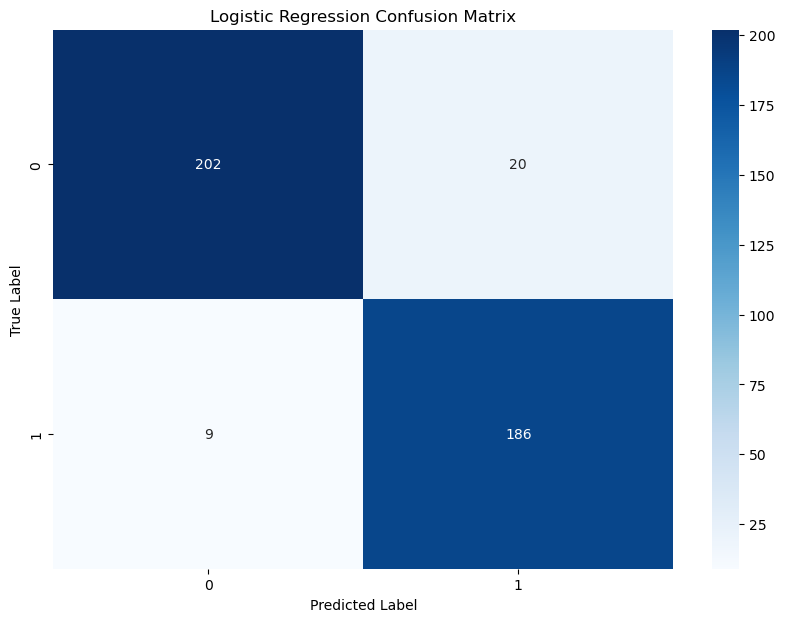

In [3]:
# Logistic Regression Model
model = LogisticRegression(labelCol="class")
model_name = "Logistic Regression"

print(f"Training {model_name}...")

# Pipeline construction
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, model])

# Train the model using the training data
trained_model = pipeline.fit(train_df)

# Make predictions on the testing data
predictions = trained_model.transform(test_df)

# Calculate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"{model_name} Test Accuracy = {accuracy:.2f}")

# Calculate other metrics
predictionAndLabels = predictions.select("prediction", "class").rdd.map(lambda row: (row[0], row[1]))
metrics = MulticlassMetrics(predictionAndLabels)

labels = predictions.select("class").distinct().collect()
labels = [row['class'] for row in labels]

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1Score = metrics.fMeasure(label)
    print(f"Class {label}:")
    print(f"  Precision = {precision:.2f}")
    print(f"  Recall = {recall:.2f}")
    print(f"  F1 Score = {f1Score:.2f}")

# Create confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()
confusion_matrix = confusion_matrix.astype(int)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{model_name} Confusion Matrix')
plt.show()

In [3]:
# Decision Tree Model
model = DecisionTreeClassifier(labelCol="class")
model_name = "Decision Tree"

print(f"Training {model_name}...")

# Pipeline construction
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, model])

# Train the model using the training data
trained_model = pipeline.fit(train_df)

# Make predictions on the testing data
predictions = trained_model.transform(test_df)

# Calculate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"{model_name} Test Accuracy = {accuracy:.2f}")

# Calculate other metrics
predictionAndLabels = predictions.select("prediction", "class").rdd.map(lambda row: (row[0], row[1]))
metrics = MulticlassMetrics(predictionAndLabels)

labels = predictions.select("class").distinct().collect()
labels = [row['class'] for row in labels]

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1Score = metrics.fMeasure(label)
    print(f"Class {label}:")
    print(f"  Precision = {precision:.2f}")
    print(f"  Recall = {recall:.2f}")
    print(f"  F1 Score = {f1Score:.2f}")

# Create confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()
confusion_matrix = confusion_matrix.astype(int)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{model_name} Confusion Matrix')
plt.show()

Training Decision Tree...


24/06/08 14:53:53 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/08 14:53:53 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/08 14:53:53 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
24/06/08 14:54:03 WARN DAGScheduler: Broadcasting large task binary with size 1033.7 KiB
24/06/08 14:54:03 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
24/06/08 14:54:04 WARN MemoryStore: Not enough space to cache rdd_101_0 in memory! (computed 419.0 MiB so far)
24/06/08 14:54:04 WARN BlockManager: Persisting block rdd_101_0 to disk instead.
24/06/08 14:54:08 WARN MemoryStore: Not enough space to cache rdd_101_0 in memory! (computed 419.0 MiB so far)
24/06/08 14:54:10 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
24/06/08 14:54:11 WARN MemoryStore: Not enough space to cache rdd_101_0 in memory! (computed 419.0 MiB so far)
24/06/08 14:54:13 WARN DAGScheduler: Broadcasting large task binary

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 53198)
Traceback (most recent call last):
  File "/Users/nuno/miniconda3/envs/learn-env-m1tf/lib/python3.9/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/nuno/miniconda3/envs/learn-env-m1tf/lib/python3.9/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/Users/nuno/miniconda3/envs/learn-env-m1tf/lib/python3.9/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/nuno/miniconda3/envs/learn-env-m1tf/lib/python3.9/socketserver.py", line 747, in __init__
    self.handle()
  File "/Users/nuno/.local/lib/python3.9/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/Users/nuno/.local/lib/python3.9/site-packages/pyspark/accumulators.py", line 267, in poll
 

ConnectionRefusedError: [Errno 61] Connection refused

In [4]:
# Random Forest Model
model = RandomForestClassifier(labelCol="class")
model_name = "Random Forest"

print(f"Training {model_name}...")

# Pipeline construction
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, model])

# Train the model using the training data
trained_model = pipeline.fit(train_df)

# Make predictions on the testing data
predictions = trained_model.transform(test_df)

# Calculate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"{model_name} Test Accuracy = {accuracy:.2f}")

# Calculate other metrics
predictionAndLabels = predictions.select("prediction", "class").rdd.map(lambda row: (row[0], row[1]))
metrics = MulticlassMetrics(predictionAndLabels)

labels = predictions.select("class").distinct().collect()
labels = [row['class'] for row in labels]

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1Score = metrics.fMeasure(label)
    print(f"Class {label}:")
    print(f"  Precision = {precision:.2f}")
    print(f"  Recall = {recall:.2f}")
    print(f"  F1 Score = {f1Score:.2f}")

# Create confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()
confusion_matrix = confusion_matrix.astype(int)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{model_name} Confusion Matrix')
plt.show()

Training Random Forest...


24/06/04 14:26:46 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/04 14:26:46 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/04 14:26:46 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/04 14:26:46 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/04 14:26:49 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
24/06/04 14:28:06 WARN DAGScheduler: Broadcasting large task binary with size 1032.7 KiB
24/06/04 14:28:07 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
24/06/04 14:28:11 WARN BlockManager: Block rdd_86_58 could not be removed as it was not found on disk or in memory
24/06/04 14:28:11 ERROR Executor: Exception in task 58.0 in stage 37.0 (TID 2103)
java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.ml.tree.impl.TreePoint$.labeledPointToTreePoint(TreePoint.scala:91)
	at org.apache.spark.ml.tree.impl.TreePoint$.$anonfun$convertToTr

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 50193)
Traceback (most recent call last):
  File "/Users/nuno/miniconda3/envs/learn-env-m1tf/lib/python3.9/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/nuno/miniconda3/envs/learn-env-m1tf/lib/python3.9/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/Users/nuno/miniconda3/envs/learn-env-m1tf/lib/python3.9/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/nuno/miniconda3/envs/learn-env-m1tf/lib/python3.9/socketserver.py", line 747, in __init__
    self.handle()
  File "/Users/nuno/.local/lib/python3.9/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/Users/nuno/.local/lib/python3.9/site-packages/pyspark/accumulators.py", line 267, in poll
 

ConnectionRefusedError: [Errno 61] Connection refused

In [4]:
# Gradient-Boosted Trees Model
model = GBTClassifier(labelCol="class")
model_name = "Gradient-Boosted Trees"

print(f"Training {model_name}...")

# Pipeline construction
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, model])

# Train the model using the training data
trained_model = pipeline.fit(train_df)

# Make predictions on the testing data
predictions = trained_model.transform(test_df)

# Calculate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"{model_name} Test Accuracy = {accuracy:.2f}")

# Calculate other metrics
predictionAndLabels = predictions.select("prediction", "class").rdd.map(lambda row: (row[0], row[1]))
metrics = MulticlassMetrics(predictionAndLabels)

labels = predictions.select("class").distinct().collect()
labels = [row['class'] for row in labels]

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1Score = metrics.fMeasure(label)
    print(f"Class {label}:")
    print(f"  Precision = {precision:.2f}")
    print(f"  Recall = {recall:.2f}")
    print(f"  F1 Score = {f1Score:.2f}")

# Create confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()
confusion_matrix = confusion_matrix.astype(int)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{model_name} Confusion Matrix')
plt.show()

Training Gradient-Boosted Trees...


24/06/04 14:16:49 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/04 14:16:49 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/04 14:16:49 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/04 14:16:49 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/04 14:16:53 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
24/06/04 14:17:56 WARN DAGScheduler: Broadcasting large task binary with size 1032.7 KiB
24/06/04 14:17:57 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
24/06/04 14:18:03 WARN MemoryStore: Not enough space to cache rdd_77_5 in memory! (computed 951.0 MiB so far)
24/06/04 14:18:03 WARN BlockManager: Persisting block rdd_77_5 to disk instead.
24/06/04 14:18:04 WARN BlockManager: Block rdd_77_58 could not be removed as it was not found on disk or in memory
24/06/04 14:18:04 ERROR Executor: Exception in task 58.0 in stage 32.0 (TID 1902)
java.lan

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 49951)
Traceback (most recent call last):
  File "/Users/nuno/miniconda3/envs/learn-env-m1tf/lib/python3.9/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/nuno/miniconda3/envs/learn-env-m1tf/lib/python3.9/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/Users/nuno/miniconda3/envs/learn-env-m1tf/lib/python3.9/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/nuno/miniconda3/envs/learn-env-m1tf/lib/python3.9/socketserver.py", line 747, in __init__
    self.handle()
  File "/Users/nuno/.local/lib/python3.9/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/Users/nuno/.local/lib/python3.9/site-packages/pyspark/accumulators.py", line 267, in poll
 

ConnectionRefusedError: [Errno 61] Connection refused

Training SVM...


24/06/08 14:55:15 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/08 14:55:16 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/06/08 14:55:16 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/08 14:55:16 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/08 14:55:16 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/08 14:55:16 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/08 14:55:16 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/08 14:55:16 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/08 14:55:17 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/08 14:55:17 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/08 14:55:17 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/06/08 14:55:17 WARN DAGSchedul

SVM Test Accuracy = 0.71


24/06/08 14:55:32 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


Class 0.0:
  Precision = 0.78
  Recall = 0.64
  F1 Score = 0.70
Class 1.0:
  Precision = 0.66
  Recall = 0.79
  F1 Score = 0.72


24/06/08 14:55:33 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


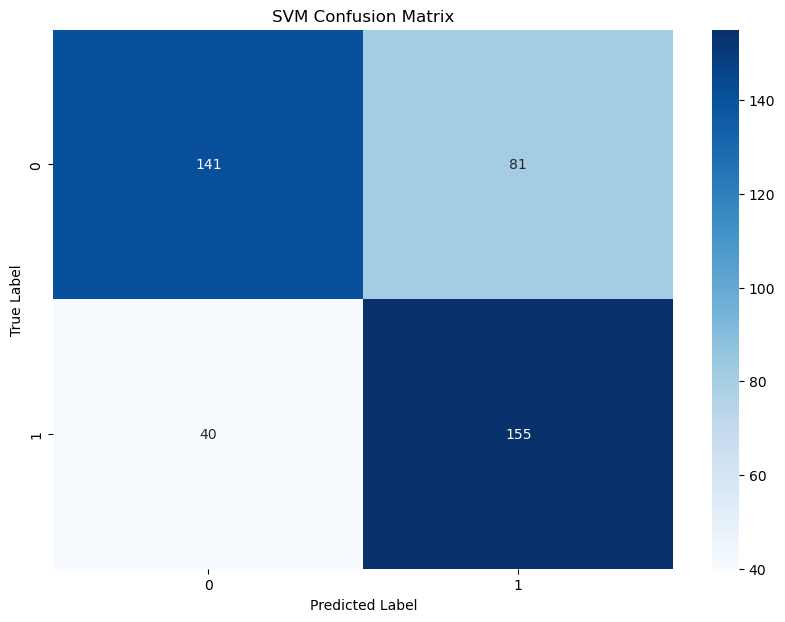

In [3]:
# SVM Model
model = LinearSVC(labelCol="class")
model_name = "SVM"

print(f"Training {model_name}...")

# Pipeline construction
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, model])

# Train the model using the training data
trained_model = pipeline.fit(train_df)

# Make predictions on the testing data
predictions = trained_model.transform(test_df)

# Calculate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"{model_name} Test Accuracy = {accuracy:.2f}")

# Calculate other metrics
predictionAndLabels = predictions.select("prediction", "class").rdd.map(lambda row: (row[0], row[1]))
metrics = MulticlassMetrics(predictionAndLabels)

labels = predictions.select("class").distinct().collect()
labels = [row['class'] for row in labels]

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1Score = metrics.fMeasure(label)
    print(f"Class {label}:")
    print(f"  Precision = {precision:.2f}")
    print(f"  Recall = {recall:.2f}")
    print(f"  F1 Score = {f1Score:.2f}")

# Create confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()
confusion_matrix = confusion_matrix.astype(int)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{model_name} Confusion Matrix')
plt.show()

### NOTAS

• Por questões de produtividade, devem ser considerados dois conjuntos de dados aquando do desenvolvimento da solução. Assim, para além dos dados originais na sua integra, deve ser utilizado um conjunto de dados de menor dimensão (sub-conjunto dos anteriores), para o caso de tarefas intensivas e frequentes, inerentes ao próprio processo de desenvolvimento da solução.

• Cada notebook (ou módulo) deverá ser autónomo em termos de fontes de dados. Sugere se que estruturem o código por forma a ler e gravar os dados entre cada uma das etapas do projeto. Isto é particularmente importante para a parte da visualização: a geração
de um gráfico ou tabela não deverá implicar a realização da simulação/processamento no mesmo instante. Preferencialmente deverá importar os dados já processados a partir de ficheiros.

### Bibliografia

https://www.kaggle.com/datasets/naveedhn/amazon-product-review-spam-and-non-spam/data?select=Clothing_Shoes_and_Jewelry     https://ieeexplore.ieee.org/abstract/document/9027828

https://www.kaggle.com/code/abhilashsampath/amazon-review-spam-detection